In [1]:
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))

In [2]:
from riskmc.data import load_prices
from riskmc.returns import log_returns
from riskmc.simulation import mc_gaussian_returns
from riskmc.simulation import mc_student_t_returns, ewma_covariance
from riskmc.risk_metrics import var, cvar, kupiec_test
from riskmc.plots import plot_t_pnl_distribution
from riskmc.plots import plot_gaussian_pnl_distribution
from riskmc.data import create_data
from riskmc.backtest import backtest_var

In [3]:
assets = ['GLD', 'SLV', 'USO', 'DBC']
weights = [0.25, 0.25, 0.25, 0.25]
#weights chosen like this as
#equities (eg SPY) dominate risk
#bonds (eg TLT) as ballast
#gold (GLD) as hedge
#QQQ as growth tilt

N_SIMS = 100_000
HORIZON = 1

In [4]:
import numpy as np

In [5]:
project_root = Path('..').resolve()
data_out_path = project_root / 'data' / 'prices.csv'
create_data(data_out_path, tickers=assets)

Saved 501 rows to /Users/ankithrangan/Desktop/Portfolio-risk-monte-carlo/data/prices.csv


Ticker,GLD,SLV,USO,DBC
Date,,,,
2026-01-28,494.559998,105.599998,76.620003,24.940001
2026-01-29,495.899994,105.570000,79.139999,25.299999
2026-01-30,444.950012,75.440002,79.519997,24.430000
2026-02-02,427.130005,72.440002,75.330002,23.540001
2026-02-03,454.290009,76.959999,77.470001,24.150000


In [6]:
prices = load_prices(data_out_path)
rets = log_returns(prices)

print(rets)
print(prices)

                 GLD       SLV       USO       DBC
Date                                              
2024-02-06  0.005211  0.001952  0.009198  0.003646
2024-02-07 -0.000265 -0.008815  0.008826  0.004539
2024-02-08 -0.000902  0.015618  0.029802  0.005420
2024-02-09 -0.003884  0.001452  0.002095  0.002699
2024-02-12 -0.002615  0.003861  0.006121  0.000449
...              ...       ...       ...       ...
2026-01-28  0.038041  0.038713  0.012609  0.012914
2026-01-29  0.002706 -0.000284  0.032360  0.014331
2026-01-30 -0.108412 -0.336037  0.004790 -0.034992
2026-02-02 -0.040874 -0.040579 -0.054130 -0.037111
2026-02-03  0.061647  0.060527  0.028012  0.025583

[500 rows x 4 columns]
                   GLD         SLV        USO        DBC
Date                                                    
2024-02-05  187.570007   20.469999  68.180000  20.113153
2024-02-06  188.550003   20.510000  68.809998  20.186625
2024-02-07  188.500000   20.330000  69.419998  20.278467
2024-02-08  188.330002   20.

In [7]:
portfolio_returns = rets @ weights
print(portfolio_returns)

Date
2024-02-06    0.005002
2024-02-07    0.001071
2024-02-08    0.012484
2024-02-09    0.000591
2024-02-12    0.001954
                ...   
2026-01-28    0.025569
2026-01-29    0.012278
2026-01-30   -0.118663
2026-02-02   -0.043173
2026-02-03    0.043942
Length: 500, dtype: float64


In [8]:
#monte carlo sim: gaussian
sim_gaussian_asset_returns = mc_gaussian_returns(rets, N_SIMS, HORIZON, ewma=True)
sim_gaussian_port_returns = sim_gaussian_asset_returns @ weights

#monte carlo sim: student-t
sim_t_asset_returns = mc_student_t_returns(rets, N_SIMS, HORIZON, ewma=True, nu=5)
sim_t_port_returns = sim_t_asset_returns @ weights


#returns: gaussian
print(sim_gaussian_asset_returns)
print(sim_gaussian_port_returns)

[[-0.01282791 -0.02319646 -0.02869433 -0.0127801 ]
 [ 0.05101904  0.17846643 -0.02204623  0.00952878]
 [ 0.00054089  0.00350884 -0.02389011 -0.00725533]
 ...
 [ 0.00417521  0.04531616 -0.01686345 -0.00422387]
 [ 0.0372877   0.10860802  0.03311419  0.02476567]
 [-0.0100624  -0.09230892  0.04821376  0.01778477]]
[-0.0193747   0.05424201 -0.00677393 ...  0.00710101  0.05094389
 -0.0090932 ]


In [9]:
#risk metrics: gaussian
var_gaussian_95 = var(sim_gaussian_port_returns, 0.95)
var_gaussian_99 = var(sim_gaussian_port_returns, 0.99)
cvar_gaussian_95 = cvar(sim_gaussian_port_returns, 0.95)
cvar_gaussian_99 = cvar(sim_gaussian_port_returns, 0.99)

var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99

(np.float64(0.057748955377527826),
 np.float64(0.08171242815956353),
 np.float64(0.0722495730222687),
 np.float64(0.09343754220657839))

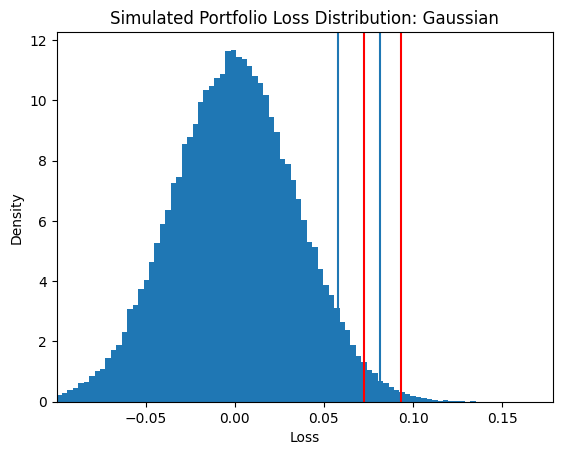

In [10]:
#plot: gaussian
plot_gaussian_pnl_distribution(sim_gaussian_port_returns, sim_t_port_returns, var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99)

In [11]:
print(np.std(sim_gaussian_port_returns))
print(np.mean(sim_gaussian_port_returns))

0.035015697962367545
-1.2449479619943312e-05


In [12]:
#returns: student-t
print(sim_t_asset_returns)
print(sim_t_port_returns)

[[-0.00823759 -0.01489588 -0.0184264  -0.00820689]
 [ 0.09816745  0.34339324 -0.0424199   0.01833464]
 [ 0.00052143  0.00338263 -0.02303079 -0.00699436]
 ...
 [ 0.00344918  0.03743608 -0.01393105 -0.00348937]
 [ 0.0402384   0.11720253  0.03573462  0.02672546]
 [-0.01759267 -0.16138907  0.08429494  0.03109414]]
[-0.01244169  0.10436886 -0.00653027 ...  0.00586621  0.05497525
 -0.01589817]


In [13]:
#risk metrics: student-t
#here difference between VaR and CVaR is a lot more noticeabe
var_t_95 = var(sim_t_port_returns, 0.95)
var_t_99 = var(sim_t_port_returns, 0.99)
cvar_t_95 = cvar(sim_t_port_returns, 0.95)
cvar_t_99 = cvar(sim_t_port_returns, 0.99)

var_t_95, var_t_99, cvar_t_95, cvar_t_99

(np.float64(0.07088523651980833),
 np.float64(0.11868574545123754),
 np.float64(0.1018257440036439),
 np.float64(0.1570681911755495))

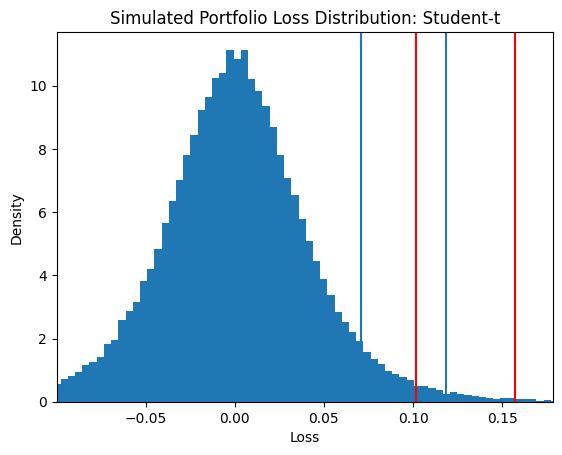

In [14]:
plot_t_pnl_distribution(sim_t_port_returns, sim_gaussian_port_returns, var_t_95, var_t_99, cvar_t_95, cvar_t_99)

In [15]:
print(np.std(sim_t_port_returns))
print(np.mean(sim_t_port_returns))

0.0452122121474661
-8.010610676656839e-05


In [16]:
#CVaR comparison
print(cvar_t_99 / cvar_gaussian_99)

1.6809966044300686


In [17]:
#Backtesting

In [18]:
var_level = 0.99

breaches_gaussian, _ = backtest_var(rets, weights=weights, var_level=var_level, model='gaussian')
breaches_t, _ = backtest_var(rets, weights=weights, var_level=var_level, model='student-t')

In [19]:
#check gaussian breach rate
gaussian_empirical_rate = breaches_gaussian.mean()
gaussian_expected_rate = 1 - var_level

print(f'expected breach rate: {gaussian_expected_rate}')
print(f'empirical breach rate: {gaussian_empirical_rate}')

#kupiec test
gau_kup_LR, gau_kup_pval = kupiec_test(breaches_gaussian, var_level)
print(gau_kup_pval)


print(
    f"Gaussian Kupiec p-value = {gau_kup_pval:.3f}. "
    "At the 5% significance level, we fail to reject the null hypothesis of correct 99% VaR coverage."
)
print(
    "This indicates that incorporating EWMA volatility materially improves Gaussian VaR calibration, "
    "though tail risk remains less robustly modeled than under the Student-t specification."
)

expected breach rate: 0.010000000000000009
empirical breach rate: 0.01366742596810934
0.4644561795217522
Gaussian Kupiec p-value = 0.464. At the 5% significance level, we fail to reject the null hypothesis of correct 99% VaR coverage.
This indicates that incorporating EWMA volatility materially improves Gaussian VaR calibration, though tail risk remains less robustly modeled than under the Student-t specification.


In [20]:
#check student-t breach rate
t_empirical_rate = breaches_t.mean()
t_expected_rate = 1 - var_level

print(f'expected breach rate: {t_expected_rate}')
print(f'empirical breach rate: {t_empirical_rate}')

#kupiec test
t_kup_LR, t_kup_pval = kupiec_test(breaches_t, var_level)
print(t_kup_pval)

if t_kup_pval < 0.05:
    print(f'as kupiec p-value = {t_kup_pval} << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null')
    print('this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics')
else:
    print(
    f"Student-t Kupiec p-value = {t_kup_pval:.3f} vs Gaussian = {gau_kup_pval:.3f}. "
    "The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, "
    "suggesting better tail-risk calibration."
)

expected breach rate: 0.010000000000000009
empirical breach rate: 0.009111617312072893
0.8493690758095626
Student-t Kupiec p-value = 0.849 vs Gaussian = 0.464. The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, suggesting better tail-risk calibration.
